In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bs4 import BeautifulSoup
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
from wordcloud import WordCloud

warnings.filterwarnings("ignore")

In [291]:
# Introduction
print("\nData Project: Tumor Board Classification")
print("This project aims to classify HTML documents as containing information about a cancer tumor board or not.")
print("We will load, preprocess, analyze the data, train a model, evaluate performance, and generate predictions.\n")


Data Project: Tumor Board Classification
This project aims to classify HTML documents as containing information about a cancer tumor board or not.
We will load, preprocess, analyze the data, train a model, evaluate performance, and generate predictions.



In [292]:
# Load Data
print("Loading data...")
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("test.csv")
tumor_keywords = pd.read_csv("keyword2tumor_type.csv")

print("Training set shape:", train_csv.shape)
print("Test set shape:", test_csv.shape)

Loading data...
Training set shape: (100, 3)
Test set shape: (48, 2)


In [293]:
# Function to Load HTML content
def read_html(doc_id):
    try:
        with open(f"htmls/{doc_id}.html", "r", encoding="latin1") as f:
            return f.read()
    except FileNotFoundError:
        return ""

train_csv["html"] = train_csv["doc_id"].apply(read_html)

In [294]:
# Extract text from HTML
def extract_html_text(html):
    bs = BeautifulSoup(html, "lxml")
    for script in bs(["script", "style"]):
        script.decompose()
    return bs.get_text(" ")

train_csv["html_text"] = train_csv["html"].apply(extract_html_text)

In [295]:
# Exploratory Data Analysis
print("\nExploratory Data Analysis...")


Exploratory Data Analysis...


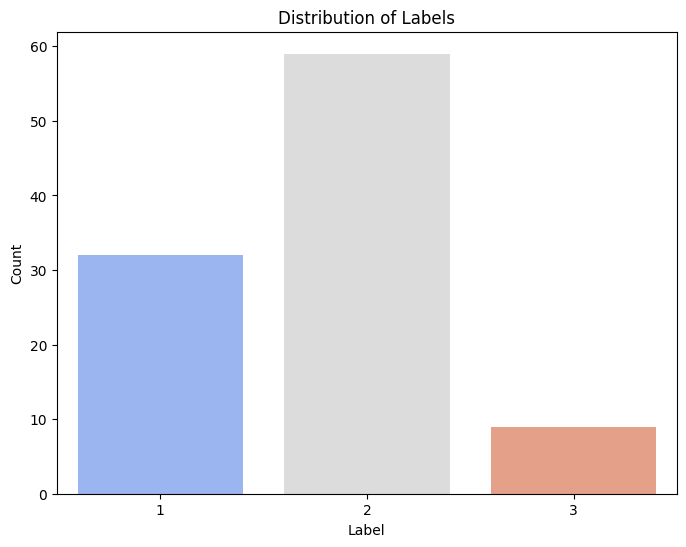

In [296]:
# Label Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=train_csv, palette="coolwarm")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

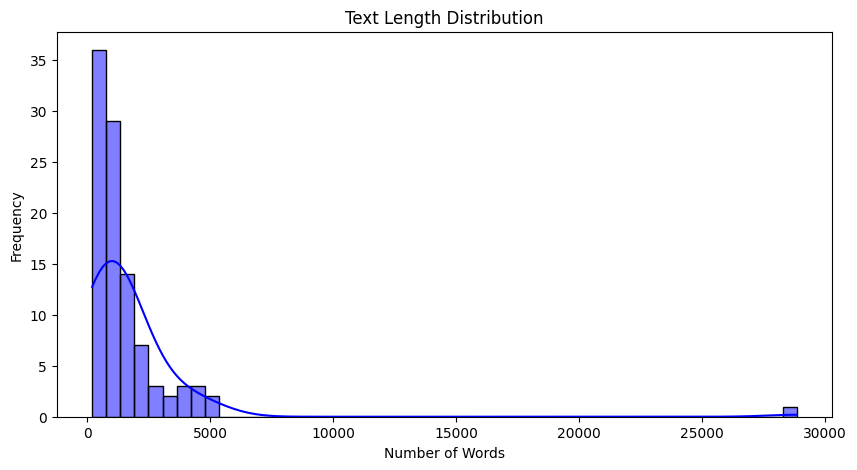

In [297]:
# Text Length Distribution
train_csv["text_length"] = train_csv["html_text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(train_csv["text_length"], bins=50, kde=True, color="blue")
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

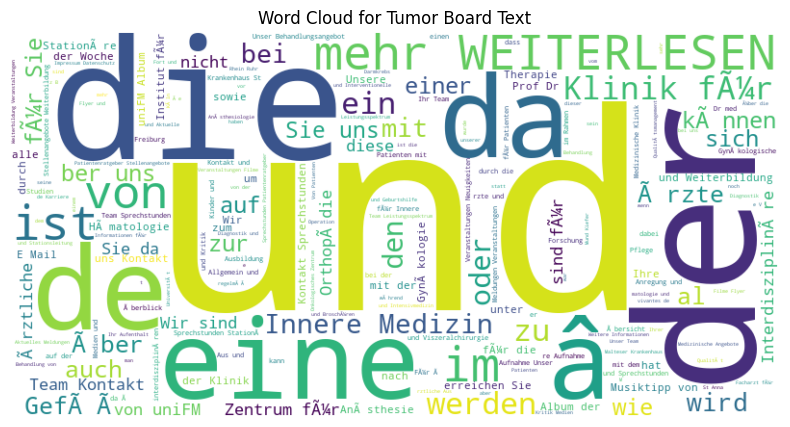

In [298]:
# Word Cloud Visualization
def generate_wordcloud(text_series, title):
    text = " ".join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(train_csv["html_text"], "Word Cloud for Tumor Board Text")

In [299]:
# Preprocessing text
def preprocess_html_text(text):
    text = preprocessing.strip_non_alphanum(text)
    text = preprocessing.strip_multiple_whitespaces(text)
    text = preprocessing.strip_punctuation(text)
    text = preprocessing.strip_numeric(text)
    text = preprocessing.stem_text(text)
    text = preprocessing.remove_stopwords(text)
    return text

train_csv["preprocessed_html_text"] = train_csv["html_text"].apply(preprocess_html_text)

In [300]:
# Modeling: Data Preparation
X_train, X_val, y_train, y_val = train_test_split(
    train_csv["preprocessed_html_text"], train_csv["label"], test_size=0.2, random_state=42
)

In [301]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [302]:
# Model Definition and Training
print("\nTraining the model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)


Training the model...


RandomForestClassifier(random_state=42)

In [303]:
# Model Evaluation
y_pred = rf.predict(X_val_tfidf)
y_pred_prob = rf.predict_proba(X_val_tfidf)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='weighted'))

Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.14      0.20         7
           2       0.47      0.80      0.59        10
           3       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.27      0.31      0.26        20
weighted avg       0.35      0.45      0.37        20

Confusion Matrix:
 [[1 6 0]
 [2 8 0]
 [0 3 0]]
ROC AUC Score: 0.5537330316742082


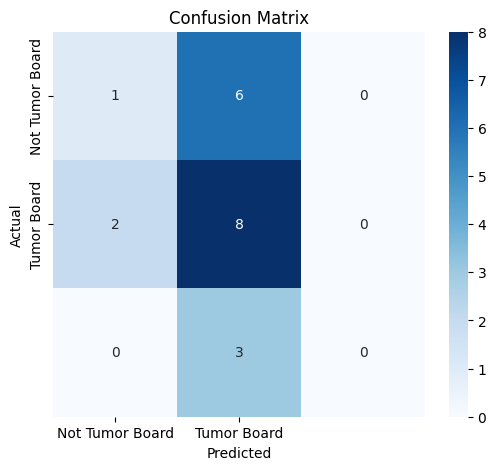

In [304]:
# Visualizing Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Tumor Board", "Tumor Board"], 
            yticklabels=["Not Tumor Board", "Tumor Board"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

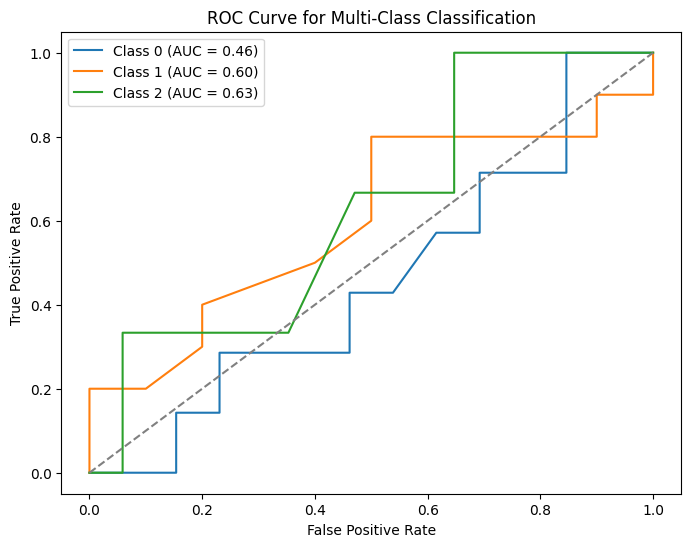

In [305]:
# Binarize the labels for multi-class classification
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
y_pred_prob = rf.predict_proba(X_val_tfidf)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_val_bin.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()

In [306]:
# Test Data Processing
test_csv["html"] = test_csv["doc_id"].apply(read_html)
test_csv["html_text"] = test_csv["html"].apply(extract_html_text)
test_csv["preprocessed_html_text"] = test_csv["html_text"].apply(preprocess_html_text)

In [307]:
# Test Data Prediction
X_test_tfidf = tfidf.transform(test_csv["preprocessed_html_text"])
test_csv["prediction"] = rf.predict(X_test_tfidf)